In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from models import Autoencoder
from utils import train_autoencoder, load_mnist, Missingness

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
missingness = Missingness()

In [4]:
training_data, testing_data = load_mnist()

train_loader = DataLoader(training_data, batch_size=128, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=128, shuffle=True)

In [5]:
corruption_type = "mcar"
corruption_kwargs = {"missing_rate": 0.2}

In [6]:
model = Autoencoder(input_dim=784, latent_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [7]:
losses = train_autoencoder(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    missingness=missingness,
    corruption_type=corruption_type,
    device=device,
    **corruption_kwargs
)

Epoch 10/10: average loss = 0.0169


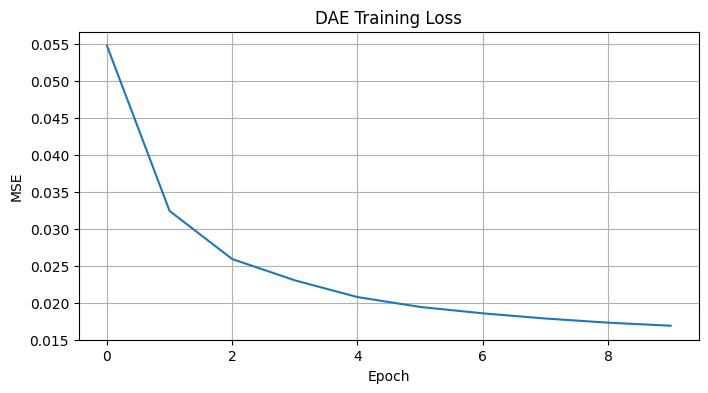

In [8]:
plt.figure(figsize=(8,4))
plt.plot(losses)
plt.title("DAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

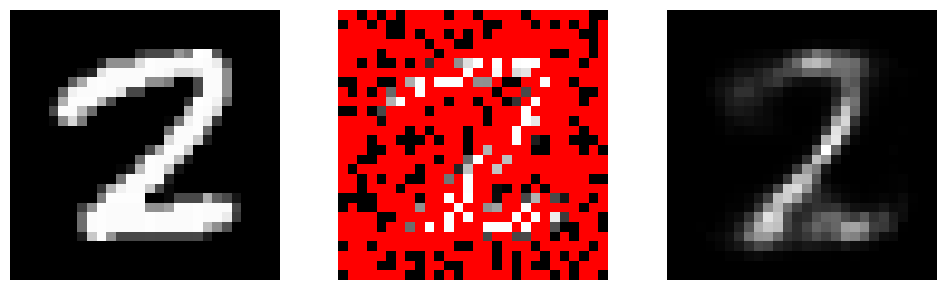

In [9]:
model.eval()

idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[idx]

img_corrupt, mask = missingness.mcar(img, missing_rate=0.7)

test = torch.nan_to_num(img_corrupt, nan=0.0)
img_reconstructed, z = model(test.view(1, -1).to(device))


# Plotting
fig, axs = plt.subplots(1, 3, figsize=(10,3))

cmap = plt.cm.gray.copy()
cmap.set_bad(color='red')

axs[0].imshow(img.squeeze(), cmap=cmap)
axs[0].axis("off")
axs[1].imshow(img_corrupt.squeeze(), cmap=cmap)
axs[1].axis("off")

axs[2].imshow(img_reconstructed.detach().cpu().squeeze().reshape(28, 28), cmap='gray')
axs[2].axis("off")

fig.tight_layout()
plt.show()